In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import json
import os
import cv2
import matplotlib.pyplot as plt
import pickle
from random import shuffle

# Load files

In [ ]:
# load annotated_files
%cd /content/drive/MyDrive/data/DocLayNet

with open('annotated_files.json', 'r') as f:
    files = json.load(f)

file_names = [file["data"]["file_name"] for file in files]
pdf_folder = os.listdir("./pdfs")

"""
  To show that what files from annotated_files
  aren't existing in pdf_folder
"""

wrong_files = []
for name in file_names:
  if name not in pdf_folder:
    wrong_files.append(name)
wrong_files.append("4470.pdf")
print(wrong_files)

# get domain list

domain_list = []
for file in files:
    domain_list.append(file["data"]["domain"])

domain_list = [element for element in set(domain_list)]
print(domain_list)

/content/drive/MyDrive/data/DocLayNet
['01_2020_TTBTTTT_434357.pdf', '11353_CV_trien_khai_nang_cap_Smartbanking_lan_41_nam_2022.pdf', '4470.pdf']
['bank', 'fpt', 'finance', 'qms', 'law']


# Mapping
LabelStudio format to DocLayNet format

In [ ]:
convert_label_name = {
    "text": "Text",
    "title": "Section-header",
    "list-item": "List-item",
    "table": "Table",
    "figure": "Picture",
    "form": "Caption",
    "footnote": "Footnote",
    "useless": "Page-header"
}

# categories
count = -1
categories = []
for key in convert_label_name:
    count += 1
    category = {}
    category["id"] = count; category["name"] = key
                                              #convert_label_name[key]
    categories.append(category)

map_category_to_id = {item["name"]: item["id"] for item in categories}

# write into json file
def write_info_to_json(files, train=True):
    json_file = {
        "images": [],
        "annotations": [],
        "categories": categories
    }
    page_id = 0 if train else 10000
    annot_id = 0 if train else 10000
    for file in files:
        page_shape = {}
        for page in file["annotations"][0]["result"]:
          page_shape[page["to_name"]] = (page["original_height"], page["original_width"]) #(height, width)

        for page_dict in file["data"]["document"]:
            page_url = page_dict["page"]
            page_info = {}
            file_page = page_url[page_url.find("page_"): page_url.find(".")] # ex: page_0
            page_name = page_url.replace("/data/local-files/?d=documents/", "")
                                        # /data/local-files/?d=documents/
            page_name = page_name.replace(".jpg", "") + ".png"
            # page info
            page_info["id"] = page_id
            page_info["file_name"] = page_name

            if file_page in page_shape:
              page_info["height"] = page_shape[file_page][0]
              page_info["width"] = page_shape[file_page][1]
              json_file["images"].append(page_info)
            elif os.path.exists(os.path.join("/content/drive/MyDrive/data/DocLayNet/PNG", page_name)):
              img_shape = cv2.imread(os.path.join("/content/drive/MyDrive/data/DocLayNet/PNG", \
                                                  page_name)).shape # (height, width, channel)
              page_info["height"] = img_shape[0]
              page_info["width"] = img_shape[1]
              json_file["images"].append(page_info)

            for id, annotation in enumerate(file["annotations"][0]["result"]):
                if annotation["to_name"] == file_page:
                  img_shape = None


                  if os.path.exists(os.path.join("/content/drive/MyDrive/data/DocLayNet/PNG", page_name)):
                    img_shape = cv2.imread(os.path.join("/content/drive/MyDrive/data/DocLayNet/PNG", \
                                                        page_name)).shape # (height, width, channel)
                  annot = {}

                  x_min = annotation["value"]["x"]*img_shape[1]/100
                  y_min = annotation["value"]["y"]*img_shape[0]/100
                  width = annotation["value"]["width"]*img_shape[1]/100
                  height = annotation["value"]["height"]*img_shape[0]/100

                  bbox = [x_min, y_min, width, height]
                  annot["bbox"] = bbox
                  annot["bbox_mode"] = 1

                  if "rectanglelabels" in annotation["value"]:
                      old_label = annotation["value"]["rectanglelabels"][0]
                  else:
                      print(annotation)
                      continue
                  annot["category_id"] = map_category_to_id[old_label.strip()]
                                         # map_category_to_id[convert_label_name[old_label.strip()]]
                  annot["image_id"] = page_id
                  annot["id"] = annot_id
                  annot["iscrowd"] = 0
                  annot["area"] = width * height

                  json_file["annotations"].append(annot)
                  annot_id += 1
            page_id += 1

    return json_file

In [ ]:
# split files into each domains

domain_dict = {domain: [] for domain in domain_list}
annotated_files = []

for annotated_file in files:
    if annotated_file["data"]["file_name"] not in wrong_files:
        domain = annotated_file['data']['domain']
        domain_dict[domain].append(annotated_file)
        annotated_files.append(annotated_file["data"]["file_name"])
    else:
        print(annotated_file["data"]["file_name"].strip(".pdf"))

01_2020_TTBTTTT_434357
11353_CV_trien_khai_nang_cap_Smartbanking_lan_41_nam_2022
4470


# Split files

In [ ]:
def train_test_split(train_size = 0.7):
    train_annotated_files = []
    test_annotated_files = []

    for domain in domain_list:
        num_train_samples = int(len(domain_dict[domain]) * train_size)

        train_annotated_files.extend(domain_dict[domain][:num_train_samples])
        test_annotated_files.extend(domain_dict[domain][num_train_samples:])

    shuffle(train_annotated_files) # shuffle data
    shuffle(test_annotated_files)

    return train_annotated_files, test_annotated_files

train_annotated_files, val_annotated_files = train_test_split()

# Analyze pages/each domain in train/val:

In [ ]:
"""
  Calculate the number of pages/each domain
  in train/val document
"""

def return_pages_dict(train=True):
  # ['bank', 'fpt', 'finance', 'qms', 'law']
  pages_anal = {
      "bank": 0,
      "fpt": 0,
      "finance": 0,
      "qms": 0,
      "law": 0
  }
  files = train_annotated_files if train else val_annotated_files
  for file in files:
    pages_anal[file["data"]["domain"]] += len(file["data"]["document"])
  return pages_anal

print(return_pages_dict())
print(return_pages_dict(train=False))

{'bank': 152, 'fpt': 7, 'finance': 596, 'qms': 100, 'law': 2021}
{'bank': 25, 'fpt': 43, 'finance': 244, 'qms': 29, 'law': 1007}


In [ ]:
# len(train_annotated_file)/len(annotated_file)
%cd /content/drive/MyDrive/data/DocLayNet

train_data = write_info_to_json(files=train_annotated_files)
val_data = write_info_to_json(files=val_annotated_files, train=False)

list_png = os.listdir("PNG")

def object(train=True):
    object = {key: [] for key in train_data}
    data = train_data if train else val_data
    ids = []

    for image in data["images"]:
        if image["file_name"] != "11353_CV_TRIEN_KHAI_NANG_CAP_SMARTBANKING_LAN_41_NAM_2022_page_3.png":
          object["images"].append(image)
          ids.append(image["id"])

    for annot in data["annotations"]:
        if annot["image_id"] in ids:
            object["annotations"].append(annot)
    object["categories"] = data["categories"]

    for id, image in enumerate(data["images"]):
      if "11353_CV_TRIEN_KHAI_NANG_CAP_SMARTBANKING_LAN_41_NAM_2022" in image["file_name"]:
          image_shape = cv2.imread("./PNG/" + image["file_name"]).shape
          object["images"][id]["height"] = image_shape[0]
          object["images"][id]["width"] = image_shape[1]

    return object

train_data = object()
val_data = object(train=False)


train_object = json.dumps(train_data)
val_object = json.dumps(val_data)

with open("COCO/train.json", "w") as file:
    file.write(train_object)

with open("COCO/val.json", "w") as file:
    file.write(val_object)

/content/drive/MyDrive/data/DocLayNet


In [ ]:
for image in train["images"]:
  if "11353_CV_TRIEN_KHAI_NANG_CAP_SMARTBANKING_LAN_41_NAM_2022" in image["file_name"]:
    print(image)

{'id': 470, 'file_name': '11353_CV_TRIEN_KHAI_NANG_CAP_SMARTBANKING_LAN_41_NAM_2022_page_0.png', 'height': 839, 'width': 588}
{'id': 471, 'file_name': '11353_CV_TRIEN_KHAI_NANG_CAP_SMARTBANKING_LAN_41_NAM_2022_page_1.png', 'height': 837, 'width': 588}
{'id': 472, 'file_name': '11353_CV_TRIEN_KHAI_NANG_CAP_SMARTBANKING_LAN_41_NAM_2022_page_2.png', 'height': 835, 'width': 588}


# Test

In [ ]:
%cd /content/drive/MyDrive/data/DocLayNet

train = json.load(open("COCO/train.json"))
val = json.load(open("COCO/val.json"))

train_names = [image["file_name"] for image in train["images"]]
val_names = [image["file_name"] for image in val["images"]]

print("Num pages: ", len(train["images"]) + len(val["images"]))
print("All pages: ", len(os.listdir("PNG")))

/content/drive/MyDrive/data/DocLayNet
Num pages:  4223
All pages:  4223


In [ ]:
train["categories"]

[{'id': 0, 'name': 'text'},
 {'id': 1, 'name': 'title'},
 {'id': 2, 'name': 'list-item'},
 {'id': 3, 'name': 'table'},
 {'id': 4, 'name': 'figure'},
 {'id': 5, 'name': 'form'},
 {'id': 6, 'name': 'footnote'},
 {'id': 7, 'name': 'useless'}]

In [ ]:
annots = train["annotations"]
print(annots[0])
categories = list(set([category["id"] for category in train["categories"]]))
print(categories)

for annot in annots:
  if int(annot["category_id"]) not in categories:
    print(annot)

{'bbox': [87.24353679812565, 110.24716912635331, 452.73601160585764, 43.24545709862994], 'bbox_mode': 1, 'category_id': 1, 'image_id': 0, 'id': 0, 'iscrowd': 0, 'area': 19578.775766905943}
[0, 1, 2, 3, 4, 5, 6, 7]


In [ ]:
import pandas as pd

dict = {"name": sorted(train_names + val_names), "grid": sorted(os.listdir("VGT_DocLayNet_grid_pkl"))}
pd.DataFrame(dict)

name  \
0     01HDCLFCI_Cam_ket_chat_luong_dich_vu_BASLA_v10...   
1     01HDCLFCI_Cam_ket_chat_luong_dich_vu_BASLA_v10...   
2     01HDCLFCI_Cam_ket_chat_luong_dich_vu_BASLA_v10...   
3     01HDCLFCI_Cam_ket_chat_luong_dich_vu_BASLA_v10...   
4     01HDCLFCI_Cam_ket_chat_luong_dich_vu_BASLA_v10...   
...                                                 ...   
4218  thongtu032021ttbttttthanghangchucdanhnghenghie...   
4219  thongtu032021ttbttttthanghangchucdanhnghenghie...   
4220  thongtu032021ttbttttthanghangchucdanhnghenghie...   
4221  thongtu032021ttbttttthanghangchucdanhnghenghie...   
4222  thongtu032021ttbttttthanghangchucdanhnghenghie...   

                                                   grid  
0     01HDCLFCI_Cam_ket_chat_luong_dich_vu_BASLA_v10...  
1     01HDCLFCI_Cam_ket_chat_luong_dich_vu_BASLA_v10...  
2     01HDCLFCI_Cam_ket_chat_luong_dich_vu_BASLA_v10...  
3     01HDCLFCI_Cam_ket_chat_luong_dich_vu_BASLA_v10...  
4     01HDCLFCI_Cam_ket_chat_luong_dich_vu_BASLA_v10...  
...                                                 ...  
4218  thongtu032021ttbttttthanghangchucdanhnghenghie...  
4219  thongtu032021ttbttttthanghangchucdanhnghenghie...  
4220  thongtu032021ttbttttthanghangchucdanhnghenghie...  
4221  thongtu032021ttbttttthanghangchucdanhnghenghie...  
4222  thongtu032021ttbttttthanghangchucdanhnghenghie...  

[4223 rows x 2 columns]

# Visualize

### Visualize image with boxes

In [ ]:
def show_image_with_bbox(image_id):
  image = train["images"][image_id]
  annots_for_image = []

  for annot in train["annotations"]:
    if annot["image_id"] == image["id"]:
      annots_for_image.append(annot)

  image = cv2.imread(os.path.join("/content/drive/MyDrive/data/DocLayNet/PNG", image["file_name"]))
  image_size = image.shape # height, width, channel

  for annot in annots_for_image:
    box = annot["bbox"]
    image = cv2.rectangle(image,
                          (int(box[0]), int(box[1])),
                          (int((box[0] + box[2])), int((box[1] + box[3]))),
                          color = (255, 0, 0),
                          thickness = 2)
  plt.imshow(image)

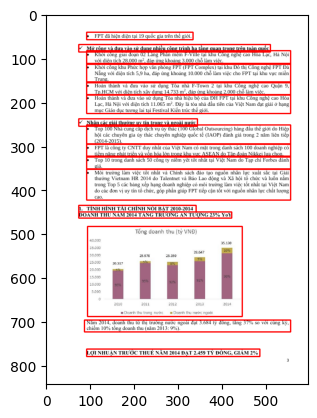

In [ ]:
show_image_with_bbox(2)

### Visualize image with grid

In [ ]:
def show_image_with_grid(image_id):
  image = train["images"][image_id]
  annots_for_image = []

  for annot in train["annotations"]:
    if annot["image_id"] == image["id"]:
      annots_for_image.append(annot)

  grid_image_path = os.path.join("/content/drive/MyDrive/data/DocLayNet/VGT_DocLayNet_grid_pkl",
                                  image["file_name"].replace(".png", ".pdf.pkl"))

  image_path = os.path.join("/content/drive/MyDrive/data/DocLayNet/PNG",
                            image["file_name"])

  image = cv2.imread(image_path)
  image_size = image.shape # height, width, channel

  with open(grid_image_path, "rb") as file:
    content = pickle.load(file)

  print(content.keys())

  for box in content["bbox_subword_list"]:
    image = cv2.rectangle(image,
                          (int(box[0]), int(box[1])),
                          (int((box[0] + box[2])), int((box[1] + box[3]))),
                          color = (255, 0, 0),
                          thickness = 2)
  plt.imshow(image)

dict_keys(['input_ids', 'bbox_subword_list', 'texts', 'bbox_texts_list'])


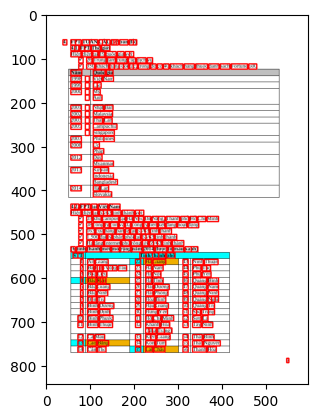

In [ ]:
show_image_with_grid(6)

# MakeGrid

In [ ]:
!pip install pdfplumber
!pip install transformers

%cd /content/drive/MyDrive/github/vision-grid-transformer/VGT/object_detection

!python create_grid_input.py \
--pdf /content/drive/MyDrive/data/DocLayNet/pdfs \
--output /content/drive/MyDrive/data/DocLayNet/VGT_DocLayNet_grid_pkl \
--tokenizer "FacebookAI/xlm-roberta-base" \
--model "doclaynet"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 856.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 24.4 MB/s eta 0:00:00
/content/drive/MyDrive/github/vision-grid-transformer/VGT/object_detection
tokenizer_config.json: 100% 25.0/25.0 [00:00<00:00, 99.5kB/s]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
config.json: 100% 615/615 [00:00<00:00, 3.26MB/s]
sentencepiece.bpe.model: 100% 5.07M/5.07M [00:00<00:00, 28.4MB/s]
tokenizer.json: 100% 9.10M/9.10M [00:00<00:00, 31.8MB/s]
